In [1]:
import datetime
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from db_utils.db_queries import sql_all_reports_with_weather
# from db_utils.mysql_db_connection import get_mysql_connection

from webscraping.scrape_fishing_data import clean_string

## Read and format the data

In [2]:
fishing_data = pd.read_csv("./raw_fishing_data.csv")

In [3]:
fishing_data.head(2)

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
0,2020-12-17,ON THE HUNT,We were on the hunt for Yellowtail today but n...,46.0,57.34,64.0,0.0,10.0,10.0,30.08
1,2020-12-18,SCRATCHING AWAY,Searched for Yellowtail again today to find no...,52.0,58.04,66.0,0.0,10.0,9.0,30.23


In [4]:
# convert the date to a date object for consistency in our analysis + make pandas happy
fishing_data.loc[:, 'date_posted'] = pd.to_datetime(fishing_data.loc[:, 'date_posted'], format="%Y-%m-%d", cache=True)

# clean punctuation from the post bodies. makes our lives harder and doesnt contribute much
fishing_data.loc[:, 'post_body'] = fishing_data.loc[:, 'post_body'].astype(str).apply(clean_string)

## Check for duplicate rows 

In [5]:
fishing_data.loc[fishing_data.duplicated(subset=['headline', 'post_body', 'date_posted'], keep=False)].sort_values("date_posted")

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
2548,2007-08-30,Indy Sportfishing Fish Report 08-30-07,Here is the report for today We fished for alb...,71.0,74.35,80.0,0.0,10.0,9.0,29.87
2547,2007-08-30,Indy Sportfishing Fish Report 08-30-07,Here is the report for today We fished for alb...,71.0,74.35,80.0,0.0,10.0,9.0,29.87
2478,2007-12-02,Indy Sportfishing Fish Report 12-02-07,Good evening we had another great day at the b...,48.0,54.43,60.0,0.0,10.0,12.0,30.41
2477,2007-12-02,Indy Sportfishing Fish Report 12-02-07,Good evening we had another great day at the b...,48.0,54.43,60.0,0.0,10.0,12.0,30.41
2354,2008-08-26,Independence Sportfishing Fish Report,Good day heres an update from our trip so far ...,69.0,71.16,75.0,0.0,10.0,9.0,29.81
2353,2008-08-26,Independence Sportfishing Fish Report,Good day heres an update from our trip so far ...,69.0,71.16,75.0,0.0,10.0,9.0,29.81
2336,2008-10-03,"Independence Fish Report for Oct. 3, 2008",Well today we continued our hunt down into the...,66.0,68.45,70.0,0.0,10.0,12.0,29.90
2335,2008-10-03,"Independence Fish Report for Oct. 3, 2008",Well today we continued our hunt down into the...,66.0,68.45,70.0,0.0,10.0,12.0,29.90
2332,2008-10-06,"Independence Fish Report for Oct. 06, 2008",Hello Here is the final report for our trip To...,62.0,69.52,79.0,0.0,10.0,13.0,29.96
2331,2008-10-06,"Independence Fish Report for Oct. 06, 2008",Hello Here is the final report for our trip To...,62.0,69.52,79.0,0.0,10.0,13.0,29.96


There are 13 duplicate posts that leaked into the data. We'll get rid of these so they don't skew any of our analysis.

In [6]:
fishing_data = fishing_data.drop_duplicates().reset_index(drop=True)
fishing_data.head(2)

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
0,2020-12-17,ON THE HUNT,We were on the hunt for Yellowtail today but n...,46.0,57.34,64.0,0.0,10.0,10.0,30.08
1,2020-12-18,SCRATCHING AWAY,Searched for Yellowtail again today to find no...,52.0,58.04,66.0,0.0,10.0,9.0,30.23


## Duplicate dates

In [7]:
# are there multiple posts for any days?
post_counts = fishing_data.date_posted.value_counts()
post_counts[post_counts >= 2]

2017-09-26    9
2017-04-30    9
2018-04-21    7
2017-04-28    7
2017-12-05    7
             ..
2014-07-10    2
2019-07-10    2
2014-07-13    2
2013-08-15    2
2007-07-29    2
Name: date_posted, Length: 410, dtype: int64

Is it concerning that dates are duplicated? Let's check one of the dates that has 9 posts.

In [8]:
sample_date = pd.Timestamp(datetime.date(2017, 9, 26))
duplicate_date_example = fishing_data.loc[fishing_data.date_posted == sample_date]
duplicate_date_example

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
498,2017-09-26,Excellent Start Kimura 8 Day,We departed Sunday on our annual Gary Kimura 8...,63.0,69.92,78.0,0.0,10.0,10.0,29.82
499,2017-09-26,beautiful dorados today,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
500,2017-09-26,beautiful yellowtail,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
501,2017-09-26,happy camper,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
502,2017-09-26,YELLOWTAIL BONANZA,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
503,2017-09-26,Matt,Matt brings in a beautiful Yellowtail,63.0,69.92,78.0,0.0,10.0,10.0,29.82
504,2017-09-26,Alex,Nice yellow today,63.0,69.92,78.0,0.0,10.0,10.0,29.82
505,2017-09-26,Robert,Robert says Hello to all my friends,63.0,69.92,78.0,0.0,10.0,10.0,29.82
506,2017-09-26,trip 1722 Jackpot winners,First place Tim Brown 57 8 Second place Vince ...,63.0,69.92,78.0,0.0,10.0,10.0,29.82


There seem to be days where the crew posts many times, sometimes without a post body. It's likely that these are accompanied by pictures on the actual site since the headlines are things like, `Matt brings in a beautiful Yellowtail`, though we didn't webscrape photos. More posts in a day may be an indicator of good fishing conditions. 

## When do posts happen?

#### Let's see how posts are distributed by year

In [9]:
# What is the earliest post and the most recent post by date?
sorted_dates = fishing_data.date_posted.sort_values()
sorted_dates.iloc[0], sorted_dates.iloc[-1]

(Timestamp('2005-06-19 00:00:00'), Timestamp('2020-12-19 00:00:00'))

In [10]:
# uncomment this to see just the numbers per year 
# (useful for spotchecking the bar plot since more plot options = room for error)

# fishing_data.date_posted.dt.year.value_counts()

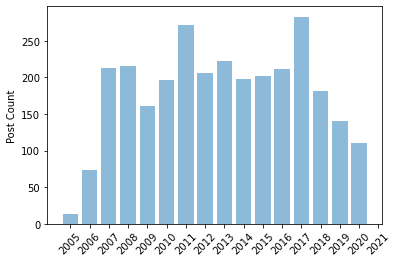

In [11]:
time_hist_options = {
    "alpha":  0.5,
    "rwidth": 0.8,
    "bins":   np.arange(2005, 2020 + 2),
    "align":  "left"
}
plt.hist(fishing_data.date_posted.dt.year, **time_hist_options)
plt.ylabel("Post Count")
plt.xticks(time_hist_options['bins'], rotation=45);

Posts were fairly consistent in the late 2000s and 2010s, though this is clear dropoff in recent years. Drops in 2020 were almost certainly correlated with covid though there was an existing downward trend.

Note: The average post per day is less than 1 for every year in the dataset. Because the crew didn't post every day, it's likely that good days are overrepresented.

#### What about the distribution by month? Is there seasonality to the posts?

In [12]:
# uncomment this to see just the numbers per month
# (useful for spotchecking the bar plot since more plot options = room for error)

# fishing_data.date_posted.dt.month.value_counts()

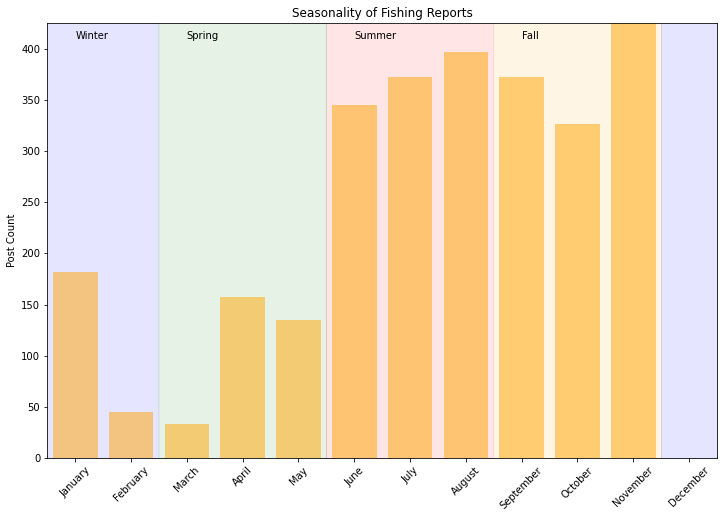

In [14]:
plt.figure(figsize=(12, 8))
month_labels = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]
month_hist_options = {
    "alpha":  0.5,
    "rwidth": 0.8,
    "bins":   np.arange(1, 12 + 1),
    "align":  "left",
    "color":  "orange"
}
plt.hist(fishing_data.date_posted.dt.month, **month_hist_options)
plt.ylabel("Post Count")
plt.xticks(month_hist_options['bins'], labels=month_labels, rotation=45);


# Custom fill patterns to emphasize seasons. Not super important
plt.fill_between([2.5, 5.49], 500, alpha=0.1, color='green', label='Spring')
plt.fill_between([5.5, 8.49], 500, alpha=0.1, color='red', label='Summer')
plt.fill_between([8.5, 11.49], 500, alpha=0.1, color='orange', label='Fall')

plt.fill_between([0, 2.49], 500, alpha=0.1, color='blue', label='Winter')
plt.fill_between([11.5, 12.5], 500, alpha=0.1, color='blue')

plt.xlim([0.5, 12.5])
plt.ylim([0, 425])

plt.annotate("Winter", [1, 410])
plt.annotate("Spring", [3, 410])
plt.annotate("Summer", [6, 410])
plt.annotate("Fall", [9, 410])

plt.title("Seasonality of Fishing Reports");

plt.savefig("post_seasonality.png", dpi=500)

Though posts aren't necessarily equivalent to business activity, this plot suggests that the fishing business may be more active in hotter months. This makes intuitive sense since we wouldn't expect people to be out in the rain or cold to catch fish, especially when the waters may be choppy or otherwise le.

### Rain patterns over the years

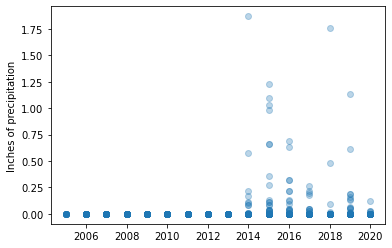

In [18]:
plt.scatter(fishing_data.date_posted.dt.year.values, fishing_data.inches_precip.values, alpha=0.3)
plt.ylabel("Inches of precipitation");

Before 2014 there is no rain data. Either the site we scraped weather data from didn't have correct measurements of the rain or we got unlucky and none of the posts occurred on days where there was rain. Given that there aren't many posts during rainy months, the latter is possible. We shouldn't use rain for anything serious in our analysis.

## Daily Temperatures

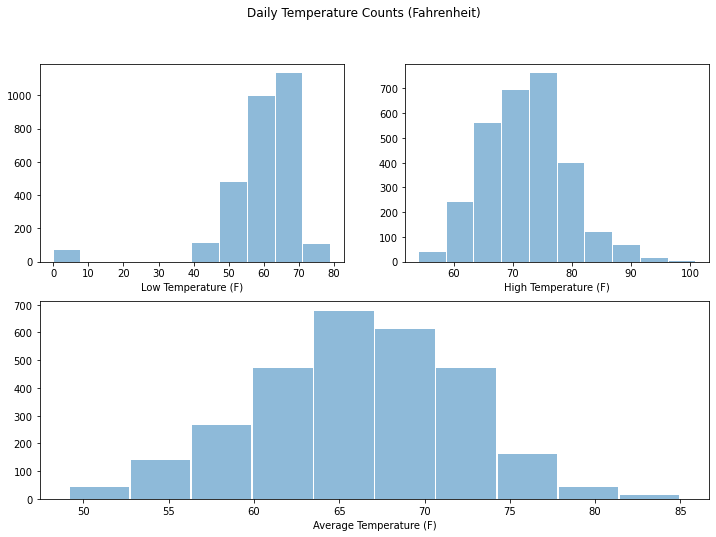

In [19]:
# thanks for the grid help: 
# https://stackoverflow.com/questions/37360568/python-organisation-of-3-subplots-with-matplotlib
import matplotlib.gridspec as gridspec

temp_plot_options = {
    "alpha":  0.5,
    "rwidth": 0.97
}

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(12, 8))
ax = plt.subplot(gs[0, 0]) # row 0, col 0
plt.suptitle("Daily Temperature Counts (Fahrenheit)")

plt.hist(fishing_data.low_temp, **temp_plot_options)
plt.xlabel("Low Temperature (F)")

ax = plt.subplot(gs[0, 1]) # row 0, col 1
plt.hist(fishing_data.high_temp, **temp_plot_options)
plt.xlabel("High Temperature (F)")

ax = plt.subplot(gs[1, :]) # row 1, span all columns
plt.hist(fishing_data.avg_temp, **temp_plot_options)
plt.xlabel("Average Temperature (F)");

The daily low temperatures have outlier values near 0. San Diego doesn't randomly hit sub-freezing temperatures, skipping everything from 32 down to 0, so we can be sure these are errors in the weather site's data.

As for the rest of the temperatures, the average and high look well-behaved. It may be worth looking for relationships between temperature and post content.

## What are the posts about?

For a first pass, we can simply look at the top words used (ignoring filler words)

In [20]:
# We'll ignore these words. They're too common to be useful
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
       'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
       'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
       'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
       'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
       'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
       'just', 'don', 'should', 'now']

stopwords = set(stopwords)

In [21]:
all_posts = " ".join(fishing_data.post_body.values)

tokens = all_posts.lower().split()
tokens = [t for t in tokens if t not in stopwords]

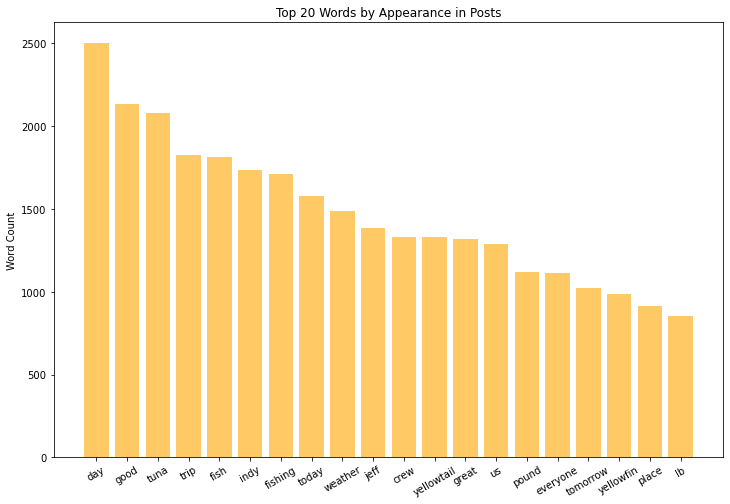

In [22]:
n = 20
top_n_words = pd.Series(tokens).value_counts().iloc[:n]

plt.figure(figsize=(12, 8))

plt.bar(top_n_words.index, top_n_words.values, alpha=0.6, color='orange')
plt.xticks(rotation=30)

plt.title(f"Top {n} Words by Appearance in Posts")
plt.ylabel("Word Count");

## Top Words in Fishing Reports

With the stopwords removed, we get mostly unique words with distinct meanings. It's a good sign that `tuna`, `yellowtail`, and `yellowfin` appear in the top words since we are more likely to be able to extract something interesting from the text. Additionally, `pound` and `lb` appearing are indicators that some posts are likely discussing the size of their catches. 

Given the top words look interesting, it may be worth looking for common phrases as well. We'll use a package called `gensim` to find these, but let's take a look at some of the math that's used under the hood to extract phrases. One way to think about phrase extraction is to think about common phrases as a collection of words that appear with each other by more than random chance. For example, the phrase "fishing is cool" is much less distinct than the phrase, "yellowfin tuna". 

"Yellowfin tuna" is a distinct phrase since the two words appear together frequently and they form a set of words that has a specific meaning together than individually. We'd like a sytematic way to find such phrases. But how? A mathematical way to approach this problem is to look at the *Pointwise Mutual Information* of word pairs.

### Beyond Single Words: Phrase Finding with Pointwise Mutual Information (PMI)

Roughly, PMI in the context of phrase finding can be thought of as measuring how associated two words are. It takes into account how often they appear altogether and compares this value to how often they appear together.

We define PMI as,

$$PMI(i, j) = log_2\frac{p(w_i, w_j)}{p(w_i)p(w_j)}$$

Where $i$ and $j$ are the indices of two words of interest, $p(w_i, w_j)$ is the probability of the two words occurring together, and $p(w_i)$ and $p(w_j)$ are the overall probabilities of the words occurring on any document (sometimes called the word frequency).


#### Limiting cases: two words are independent (not phrases)

We can expand the PMI formula using Bayes' rule like,

$$PMI(i, j) = log_2\frac{p(w_i|w_j)p(w_j)}{p(w_i)p(w_j)} = log_2\frac{p(w_i|w_j)}{p(w_i)}$$

This is interesting because if $w_i$ and $w_j$ are independent, then $p(w_i|w_j) = p(w_i)$, so the calculation is simple,

$$PMI(i, j) = log_2\frac{p(w_i|w_j)}{p(w_i)} = log_2\frac{p(w_i)}{p(w_i)} = log_2 1 = 0$$

#### Limiting cases: two words always cooccur (extreme case of phrases)

If the words always occur together, say 99% of the time, then $p(w_i|w_j) \approx 0.99 $. Let's imagine the words themselves are relatively uncommon, so their individual frequency may be something like, $p(w_i) \approx \frac{1}{10,000}$. 

Expanding the PMI calculation,

$$PMI(i, j) = log_2\frac{p(w_i|w_j)}{p(w_i)} = log_2\frac{0.99}{\frac{1}{10,000}} \approx log_2 10,000 \approx 13.3 $$




#### High PMI -> likely to be a phrase, low PMI -> words probably aren't phrases 

In the two extreme cases, we see that independent words have a PMI of 0, while words that occur together all the time have a large PMI (13.3 in our example). This idea underpins a common strategy to find phrases. We will avoid reinventing the wheel, but keep this in mind as we move forward - there is no magic to the calculations we do. 


## Let's see if Gensim can find any interesting phrases

Referencing this thorough article on [topic modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#9createbigramandtrigrammodels), we can get phrases from our text fairly simply. We'll start by dropping empty posts and doing light processing on the posts to make them into lists of words.

In [23]:
minimum_chars = 5
non_empty_posts = fishing_data.loc[fishing_data.loc[:, "post_body"].apply(lambda x: len(x.strip())) > minimum_chars]

In [24]:
split_docs = list(fishing_data.post_body.apply(lambda post: post.lower().split()).values)
print("Example documents: \n", split_docs[:2])

Example documents: 
 [['we', 'were', 'on', 'the', 'hunt', 'for', 'yellowtail', 'today', 'but', 'never', 'able', 'to', 'connect', 'we', 'covered', 'a', 'lot', 'of', 'water', 'for', 'a', 'handful', 'of', 'fish', 'were', 'not', 'giving', 'up', 'on', 'yellowtail', 'tomorrow', 'is', 'a', 'new', 'day', 'wish', 'us', 'luck', 'brian', 'indy', 'crew'], ['searched', 'for', 'yellowtail', 'again', 'today', 'to', 'find', 'non', 'biters', 'good', 'action', 'on', 'bass', 'barracuda', 'and', 'bonito', 'for', 'our', 'efforts', 'well', 'be', 'traveling', 'up', 'to', 'be', 'home', 'on', 'sunday', 'nice', 'weather', 'for', 'our', 'travels', 'brian', 'indy', 'crew']]


Here we set up the code to find phrases in our documents. Notice that scoring parameter is [`npmi`](https://en.wikipedia.org/wiki/Pointwise_mutual_information#Normalized_pointwise_mutual_information_(npmi)). It's basically the same as the PMI we talked about before, though normalized to have scores in the range [-1, 1]. A higher threshold means that it takes more for words to get merged into phrases, thus there will be less of them. This can be tuned for your problem, but I'll run with 0.5.

In [25]:
import gensim

In [26]:
phrase_options = {
    "scoring": "npmi",
    "threshold": 0.5,
    "common_terms": stopwords
}

# Build the bigram and trigram models
bigram  = gensim.models.Phrases(split_docs, min_count=5, **phrase_options) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[split_docs], **phrase_options)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod  = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [27]:
def apply_phraser_to_doc(doc):
    """
    given a list of strings like,
    
    ['hi', 'how', 'are', 'you']
    
    returns the same list with any phrases merged together via a "_" character (gensim default).
    
    PS: will combine up to ~4 words together, though it can go higher depending on stopword usage
    """
    return trigram_mod[bigram_mod[doc]]

In [28]:
# what phrases are in the first post?
[word for word in apply_phraser_to_doc(split_docs[0]) if "_" in word]

['covered_a_lot_of_water', 'wish_us_luck', 'indy_crew']

## Inspecting the phrases 

Now that we have a way to extract common phrases, let's count all of the phrases that showed up.

In [29]:
all_phrased_docs = [" ".join(apply_phraser_to_doc(doc)) for doc in split_docs]

In [30]:
# combine every post into one, split it into words, then keep the phrases
all_tokens = " ".join(all_phrased_docs).split()

all_phrases = [word for word in all_tokens if "_" in word]

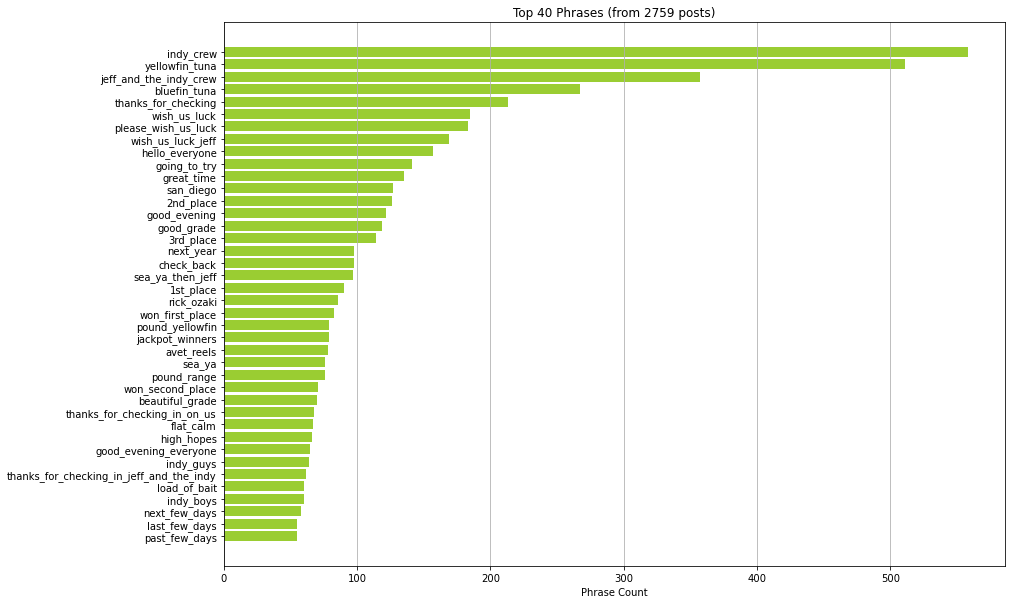

In [31]:
n = 40
top_n_phrases = pd.Series(all_phrases).value_counts().iloc[:n]

plt.figure(figsize=(14, 10))

plt.barh(top_n_phrases.index, top_n_phrases.values, alpha=1, color='yellowgreen')
plt.gca().invert_yaxis()

plt.title(f"Top {n} Phrases (from {len(non_empty_posts)} posts)")
plt.xlabel("Phrase Count")

plt.grid(axis='x');

In [32]:
def print_phrase_with_context(phrase, num_docs):
    """
    prints the first `num_docs` documents with the phrase highlighted
    
    phrase: str, "_" delimiter removed
    """
    containing_posts = non_empty_posts.loc[non_empty_posts.post_body.apply(lambda post: phrase in post.lower()), "post_body"].values
    
    color_code = "\x1b[43;1m" # ANSI highlight background with yellow. ugly but draws the eye well
    for post in containing_posts[:num_docs]:
        print(post.lower().replace(phrase, f"{color_code}{phrase}\x1b[0m"), "\n")

In [33]:
print_phrase_with_context("indy crew", 3)

we were on the hunt for yellowtail today but never able to connect we covered a lot of water for a handful of fish were not giving up on yellowtail tomorrow is a new day wish us luck brian indy crew 

searched for yellowtail again today to find non biters good action on bass barracuda and bonito for our efforts well be traveling up to be home on sunday nice weather for our travels brian indy crew 

another good day of fishing for the guys it was slow in the morning but we went looking and it paid off had great action of yellowfin tuna and some yellowtail again well be heading up the coast hunting for yellowtail tomorrow brian indy crew 



In [34]:
print_phrase_with_context("2nd place", 3)

trip 20 6 jp winners the john collins 8 day returned this morning with a beautiful catch of yellowtail and tuna a great bunch of anglers and a good time was had by all jackpot winners are 1st place mike haddock 123lb bft 2nd place jim mitchell 119lb bft 3rd place craig carlson 69 4lb bft 

thank again roger for getting the gang back together see you guys soon 1st place bret mccoy 62 4 yft 2nd place micheal hakala 58 3 yft 3rd place joe russo 55 1 yft 

1st place art ng 84 2 2nd place danny mun 80 4 3rd place ramon diaz 80 1 thanks again guys see you soon 



In [35]:
print_phrase_with_context("pound range", 3)

we started out bright and early this morning catching yellowfin tuna and yellowtail long before the sun came up after daybreak we scratched away on wahoo and there were some real trophies brought on board i m the 50 60 pound range the plan for tomorrow is more of the same and focusing on the elusive skinny we have a little more breeze now but no complaints wish us all luck tomorrow matt and independence crew 

captain mark pisano called in with an update from the independence we have good fishing for bluefin tuna we have 36 bluefin tuna and 3 yellowfin tuna i just spoke with the boat and they are stopping on another school we have been seeing good action on 25 to 40 pound bluefin tuna there is also a good chance on fish in the 60 to 80 pound range plus you always have a shot the big fish that don t seem to bite too well current schedule monday night 6 00 pm departure book now wednesday night 6 00 pm departure book now meals are included come enjoy a relaxing day on the independence 

w

# TODO: Topic model and visualize topics
# TODO: find a way to extract fish species and measure mentions

In [ ]:
non_empty_posts.shape, fishing_data.shape

In [ ]:
example = """
Once you're in the zone
The river flows down like a full stone
Water is your bed
The ripples cushion your head

I can't believe it, it is frozen
It's not the first time, I had noticed
She will deliver, I am floating
Trust in the river

I had floated down
"""

In [ ]:
def highlight_important_word(important_word, document):
    ansi_color_code = "\x1b[43;1m" # ANSI highlight background with yellow. ugly but draws the eye well
    ansi_reset_cmd  = "\x1b[0m"
    
    formatted_word  = f"{ansi_color_code}{important_word}{ansi_reset_cmd}"
    highlighted_doc = document.replace(important_word, formatted_word)
    
    print(highlighted_doc)

In [ ]:
highlight_important_word("river", example)